# Molecular Dynamics Lite workflow
This notebook implements a simple molecular dynamics (MD) workflow to demonstrate [Parsl Python parallel scripting](https://parsl-project.org/) in a Jupyter notebook. This workflow first runs MD simulations in parallel on remote resources and then renders the frames of an animation visualizing the simulation according to the schematic below.

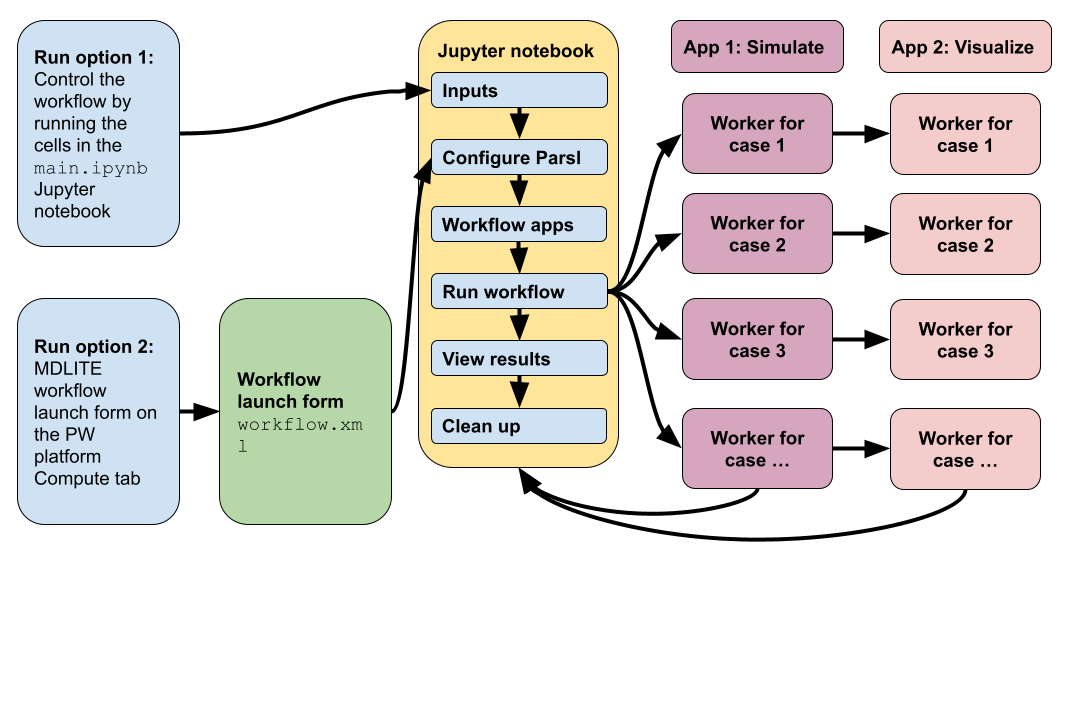

In [1]:
from IPython.display import Image
Image("images/mdlite-parameter-sweep.png")

## Step 1: Define workflow inputs
This PW workflow can be either launched from its form in the `Compute` tab or it can be run directly in this notebook.  If running directly from the notebook, the user needs to go through the extra step of defining the inputs of the workfow in the notebook.

In [20]:
import os
from os.path import exists

print('Define workflow inputs...')

# Start assuming workflow is launched from the form.
run_in_notebook=False

if (exists("./params.run")):
    print("Running from a PW form.")
    
else:
    print("Running from a notebook.")
    
    # Set flag for later
    run_in_notebook=True
    
    #TO DO: AUTOMATE THE PROCESS OF GRABING PW.CONF.
    
    # Manually set workflow inputs here (same as the
    # default values in workflow launch form)
    # params="npart;input;25:50:25|steps;input;3000:6000:3000|mass;input;0.01:0.02:0.01|trsnaps;input;5:10:5|"
    params="npart;input;25:75:25|steps;input;3000:9000:3000|mass;input;0.01:0.03:0.01|trsnaps;input;5:15:10|"
    
    print(params)
    
    # Write to params.run
    with open("params.run","w") as f:
        n_char_written = f.write(params+"\n")

Define workflow inputs...
Running from a notebook.
npart;input;25:75:25|steps;input;3000:9000:3000|mass;input;0.01:0.03:0.01|trsnaps;input;5:15:10|


## Step 2: Configure Parsl
The molecular dynamics software itself is a lightweight, precompiled executable written in C. The executable is distributed with this workflow in `./models/mdlite`, and along with input files, it is staged to the remote resources and does not need to be preinstalled.

The core visualization tool used here is a precompiled binary of [c-ray](https://github.com/vkoskiv/c-ray) distributed with this workflow in `./models/c-ray`. The executable is staged to remote resources and does not need to be preinstalled.

In addition to a Miniconda environment containing Parsl, the only other dependency of this workflow is ImageMagick's `convert` tool for image format conversion (`.ppm` to `.png`) and building animated `.gif` files from `.png` frames.

In [21]:
# Parsl essentials
import parsl
from parsl.app.app import python_app, bash_app
from parsl.data_provider.files import File

# PW essentials
from utils.path import Path
from parslpw import pwconfig,pwargs

# For embedding Design Explorer results in notebook
from IPython.display import display, HTML

# Checking inputs from the WORKFLOW FORM
if (not run_in_notebook):
    print(pwargs)

print("Configuring Parsl...")
parsl.load(pwconfig)
print("pwconfig loaded")

Configuring Parsl...
pwconfig loaded


## Step 3: Define Parsl workflow apps
These apps are decorated with Parsl's `@bash_app` and as such are executed in parallel on the compute resources that are defined in the PW configuration loaded above.  Functions that are **not** decorated are not executed in parallel on remote resources. The files that need to be staged to remote resources will be marked with Parsl's `File()` (or its PW extension, `Path()`) in the workflow.

In [4]:
print("Defining Parsl workflow apps...")

#===================================
# Molecular dynamics simulation app
#===================================
@bash_app
def md_run(stdout='md.run.stdout', stderr='md.run.stderr', inputs=[], outputs=[]):
    return '''
    %s/runMD.sh "%s" metric.out trj.out
    outdir=%s
    mkdir -p $outdir
    mv trj.out $outdir/
    mv metric.out $outdir/
    ''' % (inputs[1],inputs[0],outputs[0])

#===================================
# App to render frames for animation
#===================================
# All frames for a given simulation
# are rendered together.

# This app takes a very simple 
# approach to zero padding by adding 
# integers to 1000.
@bash_app
def md_vis_3(stdout='md.vis.stdout', stderr='md.vis.stderr', inputs=[], outputs=[]):
    return '''
    indir=%s
    outdir=%s
    mkdir -p $outdir
    for (( ff=0; ff<%s; ff++ ))
    do
        frame_num_padded=$((1000+$ff))
        %s/renderframe $indir/trj.out $outdir/f_$frame_num_padded.ppm $ff
    done
    ''' % (inputs[2],outputs[0],inputs[0],inputs[1])

Defining Parsl workflow apps...


## Step 4: Workflow
This cell executes the workflow itself.

In [5]:
print("Running workflow...")

#============================================================================
# SETUP PARAMETER SWEEP
#============================================================================
# Generate a case list from params.run (the ranges to parameters to sweep)
os.system("python ./models/mexdex/prepinputs.py params.run cases.list")

# Each line in cases.list is a unique combination of the parameters to sweep.
with open("cases.list","r") as f:
    cases_list = f.readlines()

#============================================================================
# SIMULATE
#============================================================================
# For each line in cases.list, run and visualize a molecular dynamics simulation
# These empty lists will store the futures of Parsl-parallelized apps.
# Use Path for staging because multiple files in ./models/mdlite are needed
# and mutliple files in ./results/case_*/md are sent back to the platform.
md_run_fut = []
for ii, case in enumerate(cases_list):        
    # Run simulation
    md_run_fut.append(md_run(
        inputs=[case,
            Path("./models/mdlite")],
        outputs=[Path("./results/case_"+str(ii)+"/md")]))
    
# Call results for all app futures to require
# execution to wait for all simulations to complete.
for run in md_run_fut:
    run.result()

#============================================================================
# VISUALIZE
#============================================================================
md_vis_fut = []
for ii, case in enumerate(cases_list):
    # Get number of frames to render for this case
    nframe = int(case.split(',')[4])
    
    #=========================================================
    # Render all frames for each case in one app.  This approach
    # reduces the number of SSH connections (e.g. rsync instances) 
    # compared to an app that only renders one frame at a time.
    md_vis_fut.append(md_vis_3(
        inputs=[nframe,
                Path("./models/c-ray"),
                Path("./results/case_"+str(ii)+"/md")],
        outputs=[Path("./results/case_"+str(ii)+"/vis")]))

for vis in md_vis_fut:
    vis.result()
    
# Compile frames into movies locally
for ii, case in enumerate(cases_list):
    os.system("cd ./results/case_"+str(ii)+"/vis; convert -delay 10 *.ppm mdlite.gif")

# Compile movies into Design Explorer results locally
os.system("./models/mexdex/postprocess.sh mdlite_dex.csv mdlite_dex.html ./")

Running workflow...


0

## Step 5: View results
This step is only necessary when running directly in a notebook. The outputs of this workflow are stored in the `results` folder and they can be interactively visualized with the Design Explorer by clicking on `mdlite_dex.html` which uses `mdlite_dex.csv` and the data in the `results` folder. The Design Explorer visualization is automatically embedded below.

In [17]:
# Modify width, height, and screen resolution to display as wanted
from IPython.display import IFrame
def designExplorer(url,height=500):
    return IFrame(url, width=1000, height=height)


# Makre sure path 'datafile=/pw/workflows/test_workflow/mdlite_dex.csv' is correct
designExplorer('/preview/DesignExplorer/index.html?datafile=/pw/workflows/test_workflow/mdlite_dex.csv&colorby=kinetic',height=600)

## Step 6: Clean up
This step is only necessary when running directly in a notebook. These intermediate and log files are removed to keep the workflow file structure clean if this workflow is pushed into the PW Market Place.  Please feel free to comment out these lines in order to inspect intermediate files as needed. The first two, `params.run` and `cases.list` are explicitly created by the workflow in Steps 1 and 4, respectively.  The other files are generated automatically for logging, keeping track of workers, or starting up workers. **Note that even the results are deleted!**

In [10]:
if (run_in_notebook):
    !rm -f params.run
    !rm -f cases.list
    !rm -rf runinfo
    !rm -rf __pycache__
    !rm -rf parsl-task.*
    !rm -rf *.pid
    !rm -rf *.started
    !rm -rf *.cancelled
    !rm -rf *.cogout
    !rm -rf lastid*
    !rm -rf launchcmd.*
    !rm -rf parsl-htex-worker.sh
    # Retain pw.conf if re-running this notebook on the 
    # same resource and there is no resource Off/On cycling.
    # (See README.md for more information.)
    # !rm -rf pw.conf*
    # Delete outputs
    !rm -rf ./results
    !rm -f mdlite_dex.*

# Step 6: Plots

### Pseudo Code

- Plots 2 graphs side by side: one is std vs. time, and the other is mean vs. time. 
    - Aim to show all cases on both of the graphs.

- To show all of std vs time and mean vs time 
-- Need a dataframe contains time and std of each case. Same as mean vs time 
-- To get dataframe of time and std, need to get a list of std, mean, and time for each case

- Might need to create dataframe variables for each cases here first to later be able to use it to graph all of it in the same graph.

- Loop through each case in results folder
    - Go through each time in each case
    -- Store in a time list: t_val_*, the * use to indicate the case number
        - Get root mean square of std and mean for x_pos, y_pos, and z_pos
            - Get std of each x_pos, y_pos, z_pos
            - Calculate the root mean square by using the formula:
              sqrt( std(x_pos)^2 + std(y_pos)^2 + std(z_pos)^2 )
            - Store in a rt_mean_sq_std_* list to later use it to combine with time list to create dataframe
              
            - Get mean of each x_pos, y_pos, z_pos
            - Calculate the root mean square by using the fomula:
              sqrt( mean(pos_x)^2 + mean(pos_y)^2 + mean(pos_z)^2 )
            - Store in a rt_mean_sq_mean_* list to later use it to combine with time list to create dataframe 
    - Put the time values and root mean square of std in a dataframe: combine t_val_* and rt_mean_sq_std_*. Name the dataframe as std_vs_time_*
    - Put the time values and root mean square of mean in a dataframe: combine t_val_* and rt_mean_sq_mean_*. Name the dataframe as mean_vs_time_*
    - Show the dataframe of root mean square of std vs time and root mean square of mean vs time for each case
    -- Store it in different case with different name such as case_0, case_1, case_2,...
- Plot each case on the same graph of std vs time and mean vs time, then lable cases by color code it.

In [39]:
# Import needed libraries
import pandas as pd
import numpy as np
import glob
import math 
import matplotlib.pyplot as plt

In [40]:
list_of_dirs = glob.glob("../test_workflow/results/case_*")
# print(list_of_dirs)

print("All cases")

# Loop through each case in the results folder
for i in list_of_dirs:
    # case_num = i
    # print("Case " + str(case_num))
    print(i)
    case_num = i[i.index('case'):]
    print("Case number is:", case_num)

All cases
../test_workflow/results/case_0
Case number is: case_0
../test_workflow/results/case_1
Case number is: case_1
../test_workflow/results/case_2
Case number is: case_2
../test_workflow/results/case_3
Case number is: case_3
../test_workflow/results/case_4
Case number is: case_4
../test_workflow/results/case_5
Case number is: case_5
../test_workflow/results/case_6
Case number is: case_6
../test_workflow/results/case_7
Case number is: case_7
../test_workflow/results/case_8
Case number is: case_8
../test_workflow/results/case_9
Case number is: case_9
../test_workflow/results/case_10
Case number is: case_10
../test_workflow/results/case_11
Case number is: case_11
../test_workflow/results/case_12
Case number is: case_12
../test_workflow/results/case_18
Case number is: case_18
../test_workflow/results/case_13
Case number is: case_13
../test_workflow/results/case_20
Case number is: case_20
../test_workflow/results/case_21
Case number is: case_21
../test_workflow/results/case_19
Case num

## Load data

In [43]:
# Just testing with one case right now
# need to make it work for all cases
data = pd.read_csv("../test_workflow/results/case_0/md/trj.out", sep=" ")
# print(data)
print(data.shape)

# Add name to the columns
data.columns=['time', 'var', 'x_pos', 'y_pos', 'z_pos', 'ig0', 'ig1', 'ig2', 'ig3', 'ig4', 'ig5']
print(data)

(124, 11)
     time var     x_pos     y_pos     z_pos  ig0  ig1  ig2   ig3   ig4  ig5
0       0   s  0.315908  1.295474 -1.079809  0.1  1.0  0.2  0.05  50.0  0.1
1       0   s -1.079809 -0.934800  0.917601  0.1  1.0  0.2  0.05  50.0  0.1
2       0   s  0.917601 -0.156247 -1.884792  0.1  1.0  0.2  0.05  50.0  0.1
3       0   s -1.884792 -0.534174  1.467972  0.1  1.0  0.2  0.05  50.0  0.1
4       0   s  1.467972  1.740939 -0.931221  0.1  1.0  0.2  0.05  50.0  0.1
..    ...  ..       ...       ...       ...  ...  ...  ...   ...   ...  ...
119     4   s -0.932175  0.688456 -0.568277  0.1  1.0  0.2  0.05  50.0  0.1
120     4   s -0.568277  1.875424 -0.008067  0.1  1.0  0.2  0.05  50.0  0.1
121     4   s -0.008067  0.413803 -1.143899  0.1  1.0  0.2  0.05  50.0  0.1
122     4   s -1.143899 -0.837616 -0.390179  0.1  1.0  0.2  0.05  50.0  0.1
123     4   s -0.390179 -1.730220 -2.000000  0.1  1.0  0.2  0.05  50.0  0.1

[124 rows x 11 columns]


In [44]:
# Get all time values
t_val_0 = data['time'].unique()
print(t_val_0)

# Count total data of each time values
t_val_0_count = data.groupby('time')['x_pos','y_pos','z_pos'].count()
print(t_val_0_count)

[0 1 2 3 4]
      x_pos  y_pos  z_pos
time                     
0        24     24     24
1        25     25     25
2        25     25     25
3        25     25     25
4        25     25     25


In [45]:
rt_mean_sq_std_0 = []
rt_mean_sq_mean_0 = []
# Loop through the time values list for each time value
for t in t_val_0:
    print("With time value:", t)
    # Get x_pos, y_pos, z_pos for each time value
    each_time = data.loc[data['time'] == t, 'x_pos':'z_pos']
    # print(each_time)
    
    # Get mean and std of x_pos, y_pos, z_pos for each time
    # each_time.describe()
    
    print("std of all position at selected time")
    all_pos_std = each_time.std()
    print(all_pos_std)

    print("means of all position at selected time")
    all_pos_mean = each_time.mean()
    print(all_pos_mean)
    
    # Calculate root mean square of std and mean
    rt_mean_sq_std = math.sqrt((all_pos_std['x_pos'])**2 + (all_pos_std['y_pos'])**2 + (all_pos_std['z_pos'])**2)
    print("The root mean square std:", rt_mean_sq_std)
    rt_mean_sq_std_0.append(round(rt_mean_sq_std,6))

    rt_mean_sq_mean = math.sqrt((all_pos_mean['x_pos'])**2 + (all_pos_mean['y_pos'])**2 + (all_pos_mean['z_pos'])**2)
    print("The root mean square mean:", rt_mean_sq_mean)
    rt_mean_sq_mean_0.append(round(rt_mean_sq_mean,6))
    
print("The list of root mean square std list of case_0:", rt_mean_sq_std_0)
print("The list of root mean square mean list of case_0:", rt_mean_sq_mean_0)

With time value: 0
std of all position at selected time
x_pos    1.115265
y_pos    1.280148
z_pos    1.198368
dtype: float64
means of all position at selected time
x_pos    0.160944
y_pos   -0.017602
z_pos    0.064448
dtype: float64
The root mean square std: 2.0781439858952653
The root mean square mean: 0.1742591290286528
With time value: 1
std of all position at selected time
x_pos    1.150478
y_pos    1.290167
z_pos    1.168607
dtype: float64
means of all position at selected time
x_pos    0.084853
y_pos    0.046581
z_pos    0.074506
dtype: float64
The root mean square std: 2.0865693744047773
The root mean square mean: 0.12215153865725309
With time value: 2
std of all position at selected time
x_pos    1.149448
y_pos    1.289015
z_pos    1.167592
dtype: float64
means of all position at selected time
x_pos    0.084853
y_pos    0.046581
z_pos    0.074506
dtype: float64
The root mean square std: 2.0847209744128854
The root mean square mean: 0.1221514559662324
With time value: 3
std of a

In [46]:
# Put together time and std and mean list into dataframe for plotting
# No need this step
plot_data_std_0 = pd.DataFrame(list(zip(t_val_0, rt_mean_sq_std_0)),columns =['time', 'rt_mean_sq_std'], index=None)
print("Dataframe std vs. time:")
print(plot_data_std_0)

plot_data_mean_0 = pd.DataFrame(list(zip(t_val_0, rt_mean_sq_mean_0)),columns =['time', 'rt_mean_sq_mean'])
print("Dataframe mean vs. time:")
print(plot_data_mean_0)


Dataframe std vs. time:
   time  rt_mean_sq_std
0     0        2.078144
1     1        2.086569
2     2        2.084721
3     3        2.080059
4     4        2.076310
Dataframe mean vs. time:
   time  rt_mean_sq_mean
0     0         0.174259
1     1         0.122152
2     2         0.122151
3     3         0.122151
4     4         0.122151


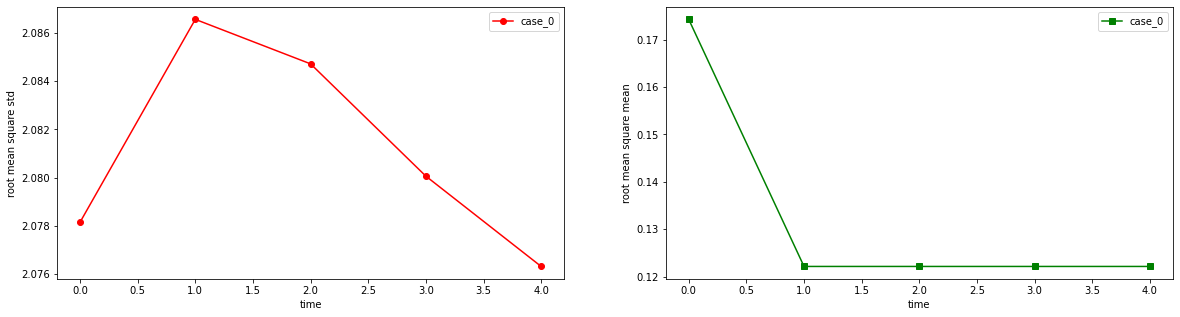

In [60]:
# Plot side by side std vs. time and mean vs. time
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
# ax0.plot(plot_data_std_0, 'r')
ax0.plot(t_val_0,rt_mean_sq_std_0,'-ro')
# ax0.plot(t_val_0,rt_mean_sq_mean_0,'-go')
ax0.set_xlabel('time')
ax0.set_ylabel('root mean square std')
ax0.legend(['case_0'])

ax1.plot(t_val_0,rt_mean_sq_mean_0,'-gs')
ax1.set_xlabel('time')
ax1.set_ylabel('root mean square mean')
ax1.legend(['case_0'])

In [48]:
# Get x_pos, y_pos, z_pos for each time value
each_time = data.loc[data['time'] == 0, 'x_pos':'z_pos']
print(each_time)

# Get mean and std of x_pos, y_pos, z_pos for each time
each_time.describe()

print("std of all position at selected time")
all_pos_std = each_time.std()
print(all_pos_std)

print("means of all position at selected time")
all_pos_mean = each_time.mean()
print(all_pos_mean)

print(type(all_pos_mean['y_pos']))

       x_pos     y_pos     z_pos
0   0.315908  1.295474 -1.079809
1  -1.079809 -0.934800  0.917601
2   0.917601 -0.156247 -1.884792
3  -1.884792 -0.534174  1.467972
4   1.467972  1.740939 -0.931221
5  -0.931221  0.697209  1.034861
6   1.034861  1.626006  0.830496
7   0.830496  0.433319 -1.247371
8  -1.247371 -0.766301  0.719423
9   0.719423  1.254149  0.790187
10  0.790187 -1.210420  1.568260
11  1.568260 -1.932731  1.623569
12  1.623569 -0.670458 -0.446041
13 -0.446041  1.790827  1.863894
14  1.863894 -1.847705  0.662159
15  0.662159 -1.205449 -1.039934
16 -1.039934 -1.086712 -0.030054
17 -0.030054 -1.120618  1.767667
18  1.767667  1.173745 -0.872912
19 -0.872912  1.232248 -0.571650
20 -0.571650  1.877759 -0.008067
21 -0.008067  0.413803 -1.197316
22 -1.197316 -0.762100 -0.390179
23 -0.390179 -1.730220 -2.000000
std of all position at selected time
x_pos    1.115265
y_pos    1.280148
z_pos    1.198368
dtype: float64
means of all position at selected time
x_pos    0.160944
y_pos   -0.0

In [49]:
# Calculate root mean square of std and mean
rt_mean_sq_std = math.sqrt((all_pos_std['x_pos'])**2 + (all_pos_std['y_pos'])**2 + (all_pos_std['z_pos'])**2)
print(rt_mean_sq_std)

rt_mean_sq_mean = math.sqrt((all_pos_mean['x_pos'])**2 + (all_pos_mean['y_pos'])**2 + (all_pos_mean['z_pos'])**2)
print(rt_mean_sq_mean)

2.0781439858952653
0.1742591290286528
